In [1]:
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr

import matplotlib.pyplot as plt


In [2]:
#Load plasmid data
plasmid_dict = isoio.load('../data/random_mpra_legacy/combined_library/processed_data_lifted/apa_plasmid_data_legacy')
plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']


In [3]:
#Load plasmid test set predictions

model_name = 'aparent_theano_legacy_30_31_34_pasaligned'

test_pred_dict = isoio.load('predictions/apa_plasmid_data_legacy/' + model_name + '_test_predictions')
test_pred_df = test_pred_dict['plasmid_df']
test_cuts_pred = test_pred_dict['cut_prob']


In [4]:
#Join dataframe with prediction table and calculate true cut probabilities

plasmid_df['row_index'] = np.arange(len(plasmid_df), dtype=np.int)
test_pred_df['row_index'] = np.arange(len(test_pred_df), dtype=np.int)

test_df = plasmid_df.join(test_pred_df.set_index('seq'), on='seq', how='inner', lsuffix='_true', rsuffix='_pred')

cut_true = np.array(plasmid_cuts[np.ravel(test_df['row_index_true']), :].todense())

cut_pred = np.array(test_cuts_pred[np.ravel(test_df['row_index_pred']), :].todense())

#Calculate isoform proportions and log odds values

iso_true = np.ravel(test_df['proximal_count'] / test_df['total_count'])
iso_pred = np.ravel(test_df['iso_pred'])
iso_pred_from_cuts = np.sum(cut_pred[:, 60: 60 + 30], axis=-1)

lib = np.array(test_df['library'].values, dtype=np.object)
lib_index = np.array(test_df['library_index'].values, dtype=np.int)


In [5]:
print('Test set n = ' + str(len(test_df)))

Test set n = 124608


In [26]:
def safe_log(x, minval=0.01):
    return np.log(x.clip(min=minval))

def plot_isoform_logodds_scatter(iso_true, iso_pred, lib_index, included_libs, x_label='Predicted Isoform Log Odds', y_label='Observed Isoform Log Odds') :
    #Filter on included libraries
    included_libs = np.array(included_libs)
    
    keep_index = np.array([True if lib_index[i] in included_libs else False for i in range(lib_index.shape[0])], dtype=np.bool)

    #Filter nan-logits
    keep_index = keep_index & (iso_true < 0.9999)
    iso_true = iso_true[keep_index][-len(included_libs) * 8000:]
    iso_pred = iso_pred[keep_index][-len(included_libs) * 8000:]
    lib_index = lib_index[keep_index][-len(included_libs) * 8000:]

    logodds_true = safe_log(iso_true / (1. - iso_true))
    logodds_pred = safe_log(iso_pred / (1. - iso_pred))
    
    #Compute isoform log odds pearson r correlation
    r_val, _ = pearsonr(logodds_pred, logodds_true)

    print('Isoform Log Odds Test Set R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(iso_true.shape[0]))

    f = plt.figure(figsize=(5, 5))

    plt.scatter(logodds_pred, logodds_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.05, color='black')
    min_x = max(np.min(logodds_pred), np.min(logodds_true))
    max_x = min(np.max(logodds_pred), np.max(logodds_true))
    min_y = max(np.min(logodds_pred), np.min(logodds_true))
    max_y = min(np.max(logodds_pred), np.max(logodds_true))
    plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    plt.axis([np.min(logodds_pred), np.max(logodds_pred), np.min(logodds_true), np.max(logodds_true)])
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    plt.show()
    plt.close()


Evaluate test set of libraries TOMM5, Alien1, Alien2, ATR, AARS, SOX13
Isoform Log Odds Test Set R^2 = 0.88, n = 72000


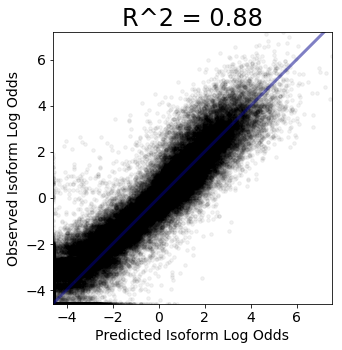

Evaluate test set of libraries HSPE1, SNHG6, WHAMMP2
Isoform Log Odds Test Set R^2 = 0.54, n = 24000


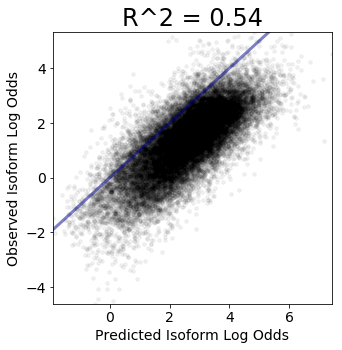

This test shows that cumulative cuts correlate with isoform prediction
Isoform Log Odds Test Set R^2 = 0.94, n = 72000


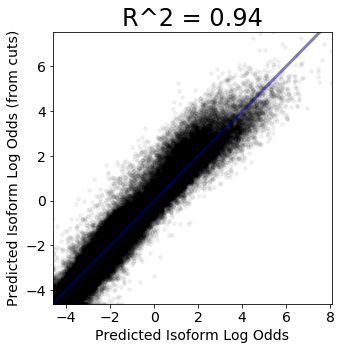

In [27]:
#Evaluate test set isoform prediction performance over all random libraries

print("Evaluate test set of libraries TOMM5, Alien1, Alien2, ATR, AARS, SOX13")

included_libs = [2, 5, 8, 11, 20, 22, 30, 31, 34]
plot_isoform_logodds_scatter(iso_true, iso_pred, lib_index, included_libs)

print("Evaluate test set of libraries HSPE1, SNHG6, WHAMMP2")

included_libs = [32, 33, 35]
plot_isoform_logodds_scatter(iso_true, iso_pred, lib_index, included_libs)

print("This test shows that cumulative cuts correlate with isoform prediction")

included_libs = [2, 5, 8, 11, 20, 22, 30, 31, 34]
plot_isoform_logodds_scatter(iso_pred, iso_pred_from_cuts, lib_index, included_libs, x_label='Predicted Isoform Log Odds', y_label='Predicted Isoform Log Odds (from cuts)')

In [65]:
def safe_log(x, minval=0.01):
    return np.log(x.clip(min=minval))

def plot_inidividual_library_scatters(iso_true, iso_pred, lib_index, included_libs, n=8000) :
    for i, li in enumerate(included_libs) :

        iso_true_lib = iso_true[lib_index == li][-n:]
        iso_pred_lib = iso_pred[lib_index == li][-n:]

        f, ax = plt.subplots(1, 2, figsize=(8, 4))

        #Evaluate isoform proportions
        r_val, _ = pearsonr(iso_pred_lib, iso_true_lib)

        print('Library test set = ' + included_lib_names[i])
        print('Isoform Proportion R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(iso_true_lib.shape[0]))

        ax[0].scatter(iso_pred_lib, iso_true_lib, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
        ax[0].plot([0, 1], [0, 1], alpha=0.5, color='darkblue', linewidth=3)

        plt.sca(ax[0])
        plt.axis([0, 1, 0, 1])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Pred Proportion", fontsize=14)
        plt.ylabel("True Proportion", fontsize=14)
        plt.title(included_lib_names[i] + ' (R^2 = ' + str(round(r_val**2, 2)) + ')', fontsize=14)

        #Evaluate isoform log odds
        iso_true_lib = iso_true[lib_index == li]
        iso_pred_lib = iso_pred[lib_index == li]
        keep_index = (iso_true_lib < 0.99999)
        iso_true_lib = iso_true_lib[keep_index][-n:]
        iso_pred_lib = iso_pred_lib[keep_index][-n:]

        logodds_pred_lib = np.ravel(safe_log(iso_pred_lib / (1. - iso_pred_lib)))
        logodds_true_lib = np.ravel(safe_log(iso_true_lib / (1. - iso_true_lib)))

        r_val, _ = pearsonr(logodds_pred_lib, logodds_true_lib)

        print('Isoform Log Odds R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(iso_true_lib.shape[0]))

        ax[1].scatter(logodds_pred_lib, logodds_true_lib, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
        min_x = max(np.min(logodds_pred_lib), np.min(logodds_true_lib))
        max_x = min(np.max(logodds_pred_lib), np.max(logodds_true_lib))
        min_y = max(np.min(logodds_pred_lib), np.min(logodds_true_lib))
        max_y = min(np.max(logodds_pred_lib), np.max(logodds_true_lib))
        ax[1].plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

        plt.sca(ax[1])
        plt.axis([np.min(logodds_pred_lib), np.max(logodds_pred_lib), np.min(logodds_true_lib), np.max(logodds_true_lib)])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Pred Log Odds", fontsize=14)
        plt.ylabel("True Log Odds", fontsize=14)
        plt.title(included_lib_names[i] + ' (R^2 = ' + str(round(r_val**2, 2)) + ')', fontsize=14)

        plt.tight_layout()
        plt.show()
        plt.close()


Evaluate test set of individual libraries
Library test set = TOMM5 1
Isoform Proportion R^2 = 0.6, n = 8000
Isoform Log Odds R^2 = 0.57, n = 8000


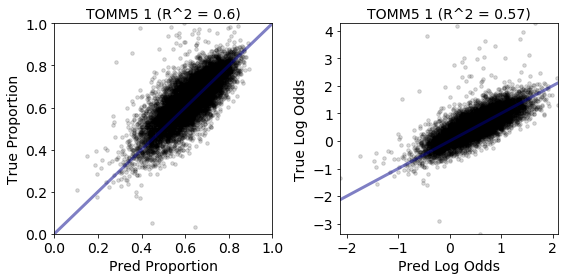

Library test set = TOMM5 2
Isoform Proportion R^2 = 0.65, n = 8000
Isoform Log Odds R^2 = 0.6, n = 8000


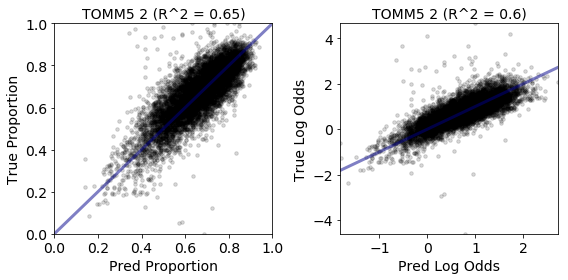

Library test set = TOMM5 3
Isoform Proportion R^2 = 0.8, n = 8000
Isoform Log Odds R^2 = 0.7, n = 8000


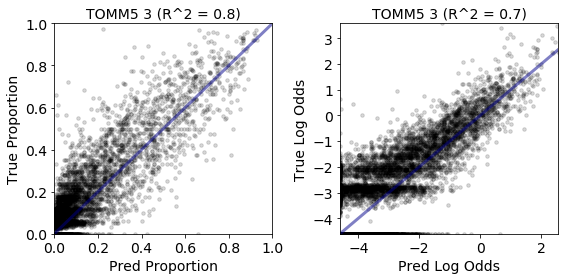

Library test set = TOMM5 4
Isoform Proportion R^2 = 0.78, n = 8000
Isoform Log Odds R^2 = 0.78, n = 8000


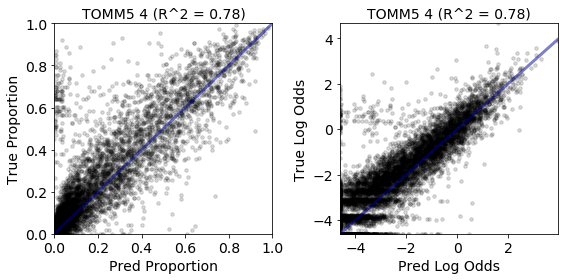

Library test set = Alien2
Isoform Proportion R^2 = 0.85, n = 8000
Isoform Log Odds R^2 = 0.85, n = 8000


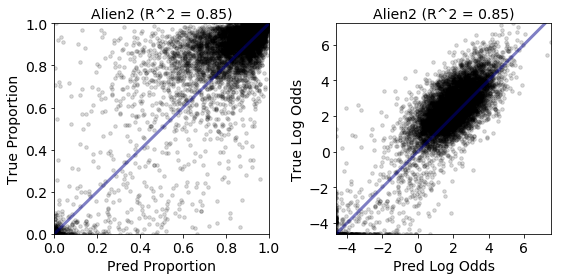

Library test set = Alien1
Isoform Proportion R^2 = 0.86, n = 8000
Isoform Log Odds R^2 = 0.83, n = 8000


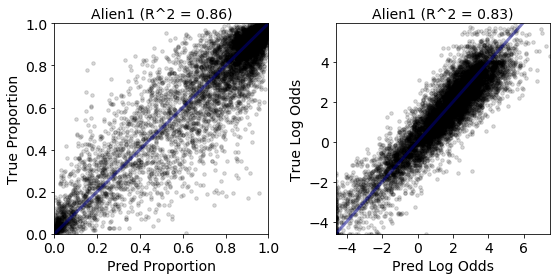

Library test set = ATR
Isoform Proportion R^2 = 0.5, n = 8000
Isoform Log Odds R^2 = 0.47, n = 8000


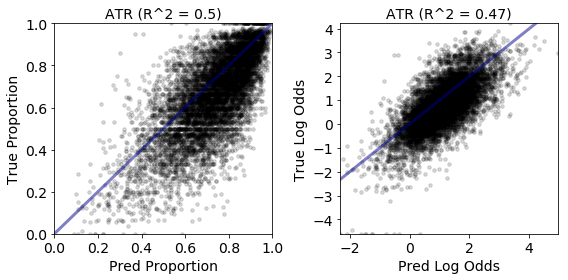

Library test set = AARS
Isoform Proportion R^2 = 0.78, n = 8000
Isoform Log Odds R^2 = 0.76, n = 8000


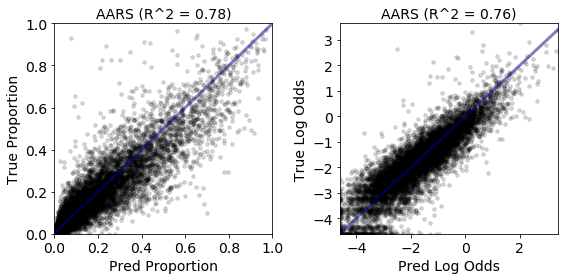

Library test set = HSPE1
Isoform Proportion R^2 = 0.59, n = 8000
Isoform Log Odds R^2 = 0.64, n = 8000


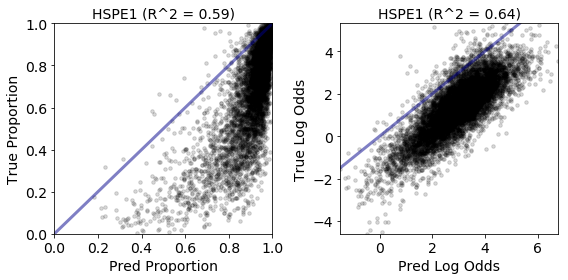

Library test set = SNHG6
Isoform Proportion R^2 = 0.46, n = 8000
Isoform Log Odds R^2 = 0.46, n = 8000


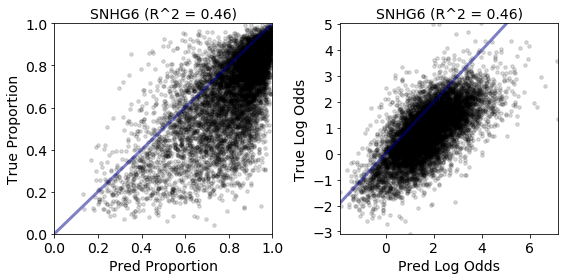

Library test set = SOX13
Isoform Proportion R^2 = 0.76, n = 8000
Isoform Log Odds R^2 = 0.72, n = 8000


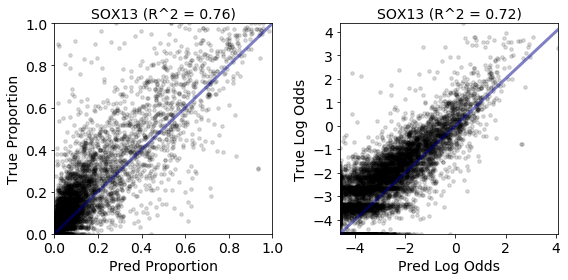

Library test set = WHAMMP2
Isoform Proportion R^2 = 0.59, n = 8000
Isoform Log Odds R^2 = 0.47, n = 8000


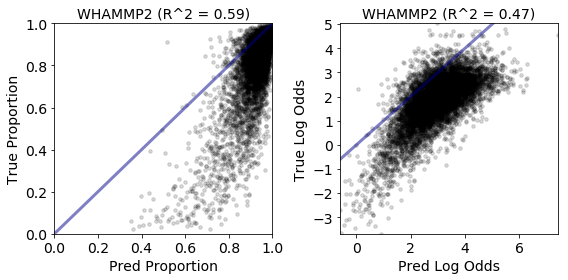

In [35]:
#Evaluate test set isoform prediction performance on individual random libraries

print("Evaluate test set of individual libraries (n = 8000 per library)")

included_libs = [2, 5, 8, 11, 20, 22, 30, 31, 32, 33, 34, 35]
included_lib_names = ['TOMM5 1', 'TOMM5 2', 'TOMM5 3', 'TOMM5 4', 'Alien2', 'Alien1', 'ATR', 'AARS', 'HSPE1', 'SNHG6', 'SOX13', 'WHAMMP2']

plot_inidividual_library_scatters(iso_true, iso_pred, lib_index, included_libs)


Evaluate test set of held-out libraries (n = 1000 per library)
Library test set = HSPE1
Isoform Proportion R^2 = 0.64, n = 1000
Isoform Log Odds R^2 = 0.69, n = 1000


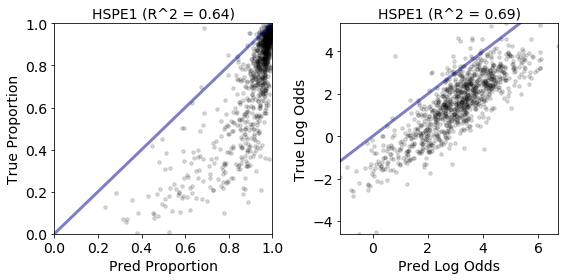

Library test set = SNHG6
Isoform Proportion R^2 = 0.47, n = 1000
Isoform Log Odds R^2 = 0.46, n = 1000


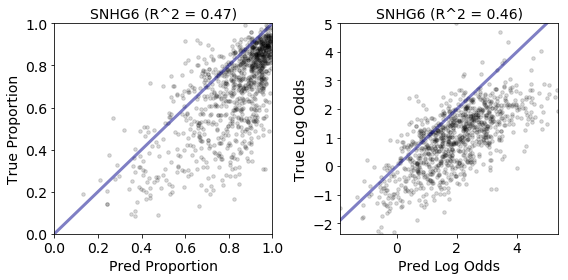

Library test set = WHAMMP2
Isoform Proportion R^2 = 0.65, n = 1000
Isoform Log Odds R^2 = 0.55, n = 1000


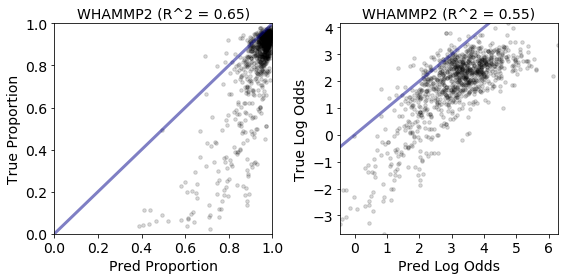

In [70]:
#Evaluate test set isoform prediction performance on individual random libraries

print("Evaluate test set of held-out libraries (n = 1000 per library)")

included_libs = [32, 33, 35]
included_lib_names = ['HSPE1', 'SNHG6', 'WHAMMP2']

plot_inidividual_library_scatters(iso_true, iso_pred, lib_index, included_libs, n=1000)


In [39]:
def plot_cut_position_scatters(cut_true, cut_pred, lib_index, included_libs) :
    #Filter on included libraries
    included_libs = np.array(included_libs)
    
    keep_index = np.array([True if lib_index[i] in included_libs else False for i in range(lib_index.shape[0])], dtype=np.bool)

    cut_start = 57
    cut_end = 107
    
    #Filter nan-logits
    keep_index = keep_index & (np.sum(cut_true[:, cut_start:cut_end], axis=-1) > 0.5)
    cut_true = cut_true[keep_index, :][-8000:]
    cut_pred = cut_pred[keep_index, :][-8000:]
    lib_index = lib_index[keep_index][-8000:]
    
    cut_true = cut_true[:, cut_start:cut_end] / np.sum(cut_true[:, cut_start:cut_end], axis=-1).reshape(-1, 1)
    cut_pred = cut_pred[:, cut_start:cut_end] / np.sum(cut_pred[:, cut_start:cut_end], axis=-1).reshape(-1, 1)
    
    mean_cut_true = np.sum(np.arange(cut_end - cut_start).reshape(1, -1) * cut_true, axis=-1)
    mean_cut_pred = np.sum(np.arange(cut_end - cut_start).reshape(1, -1) * cut_pred, axis=-1)
    
    #Compute isoform log odds pearson r correlation
    r_val, _ = pearsonr(mean_cut_pred, mean_cut_true)

    print('Mean Cut Position Test Set R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(cut_true.shape[0]))

    f, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].scatter(mean_cut_pred, mean_cut_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='darkblue')

    plt.sca(ax[0])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Pred Mean Cut Position", fontsize=14)
    plt.ylabel("True Mean Cut Position", fontsize=14)
    
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    
    sort_index = np.argsort(mean_cut_true)
    mean_cut_true = mean_cut_true[sort_index]
    mean_cut_pred = mean_cut_pred[sort_index]

    ax[1].scatter(mean_cut_pred, np.arange(mean_cut_true.shape[0]), s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='darkblue')
    ax[1].plot(mean_cut_true, np.arange(mean_cut_true.shape[0]), color='darkred', linewidth=3, linestyle='--')
    
    plt.sca(ax[1])
    plt.xticks(fontsize=14)
    plt.yticks([], fontsize=14)

    plt.xlabel("Pred Mean Cut Position", fontsize=14)
    plt.ylabel("Sequences", fontsize=14)
    
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    
    plt.tight_layout()
    plt.show()
    plt.close()



Evaluate test set cut site prediction on Alien1 library
Mean Cut Position Test Set R^2 = 0.82, n = 8000


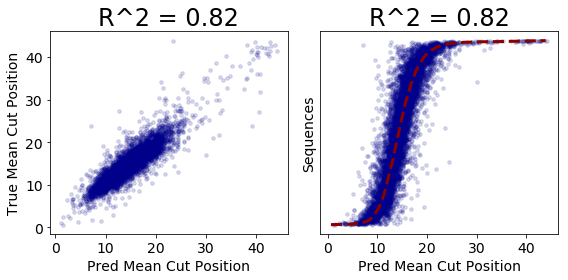

Evaluate test set cut site prediction on HSPE1 library
Mean Cut Position Test Set R^2 = 0.58, n = 8000


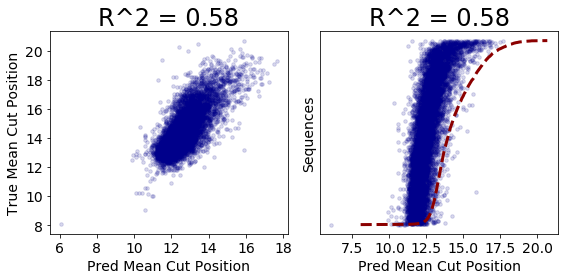

In [40]:
#Evaluate predicted vs. observed mean cut position on test sets

print("Evaluate test set cut site prediction on Alien1 library (n = 8000)")

plot_cut_position_scatters(cut_true, cut_pred, lib_index, [22])

print("Evaluate test set cut site prediction on HSPE1 library (n = 8000)")

plot_cut_position_scatters(cut_true, cut_pred, lib_index, [35])